In [2]:
import sys
sys.path.append('../')
import re
import os
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas()
import json
from utils.rouge import RougeL
from utils.precision_recall_f1 import precision_recall_f1
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
matplotlib.style.use('ggplot')

## 保持全局长度下计算 label 的 ceil rougel

In [2]:
from utils.rouge import RougeL

ans_pattern = re.compile(r'@content\d@')

def find_answer_in_docid(answer):
    docs = ans_pattern.findall(answer)
    return list(set([int(doc[-2:-1]) for doc in docs]))

def calc_ceil_rougel(answer_text, sample):
    # 计算抽取的 fake answer 以及对应的 ceil rougel
    fake_answers = [sample['documents'][answer_label[0]]['content'][answer_label[1]: answer_label[2] + 1]
                    for answer_label in sample['answer_labels']]
    sample['fake_answers'] = fake_answers

    if len(fake_answers) == 0:
        sample['ceil_rougel'] = 0
    else:
        ceil_rougel = RougeL().add_inst(cand=''.join(fake_answers), ref=answer_text).get_score()
        sample['ceil_rougel'] = ceil_rougel


In [3]:
def calc_sample_ceil_rougel(sample):
    answer = sample['answer']
    ans_in_docids = find_answer_in_docid(answer)
    answer_texts = []
    for ans_in_docid in ans_in_docids:
        answer_strs = answer.split('@content{}@'.format(ans_in_docid))
        for answer_str in answer_strs:
            answer_str = answer_str.strip()  # important
            # @content1@ 包裹的实际答案文本
            if answer_str != '' and '@content' not in answer_str:
                answer_str = answer_str.replace('content{}@'.format(ans_in_docid), '')
                answer_texts.append(answer_str)

    # 拼接的答案文本
    answer_text = ''.join(answer_texts)
    calc_ceil_rougel(answer_text, sample)

In [5]:
ori_ceil_rougels = []

zero_ceil_rougel_samples = set()

with open('../input/mrc_dataset/all_train_full_content.json') as f:
    lines = f.readlines()
    for line in tqdm(lines):
        if not line.startswith('{'):
            continue

        sample = json.loads(line.strip())
        calc_sample_ceil_rougel(sample)
        ori_ceil_rougels.append(sample['ceil_rougel'])
        
        if sample['ceil_rougel'] == 0:
            zero_ceil_rougel_samples.add(sample['question_id'])

100%|██████████| 24843/24843 [00:08<00:00, 2917.30it/s]


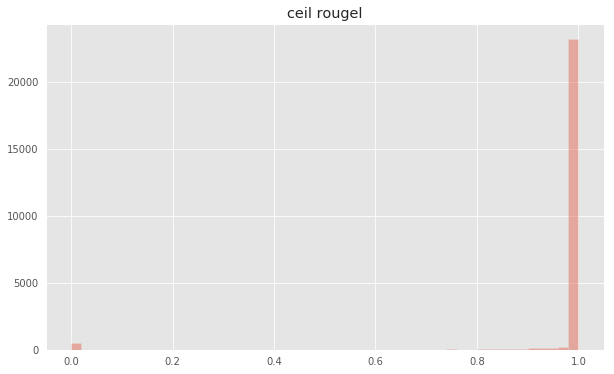

In [6]:
plt.figure(figsize=(10, 6))
sns.distplot(ori_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [7]:
ori_ceil_rougels = np.array(ori_ceil_rougels)

In [8]:
print('total:', ori_ceil_rougels.shape[0])
print('ceil rougel < 0.20:', ori_ceil_rougels[ori_ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', ori_ceil_rougels[ori_ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', ori_ceil_rougels[ori_ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', ori_ceil_rougels[ori_ceil_rougels == 1].shape[0])

total: 24843
ceil rougel < 0.20: 515
ceil rougel > 0.95: 23511
ceil rougel = 0: 498
ceil rougel = 1: 23117


In [9]:
ori_ceil_rougels[ori_ceil_rougels == 1].shape[0] / ori_ceil_rougels.shape[0]

0.930523688765447

In [10]:
np.mean(ori_ceil_rougels)

0.971559387448041

In [11]:
len(zero_ceil_rougel_samples)

498

In [12]:
# 生成 label 之前的 raw 数据

bad_case_raw_samples = []
for i in range(10):
    path = '../input/raw/split_train_0{}'.format(i)
    if not os.path.isfile(path):
        continue

    with open(path) as f:
        print(path)
        for line in f:
            sample = json.loads(line.strip())
            if sample['question_id'] in zero_ceil_rougel_samples:
                bad_case_raw_samples.append(line)


../input/raw/split_train_00
../input/raw/split_train_01
../input/raw/split_train_02
../input/raw/split_train_03
../input/raw/split_train_04
../input/raw/split_train_05
../input/raw/split_train_06
../input/raw/split_train_07
../input/raw/split_train_08
../input/raw/split_train_09


In [14]:
with open('../input/bad_case_raw_samples.json', 'w', encoding='utf8') as f:
    f.writelines(bad_case_raw_samples)

## bad case 优化后的 ceil rougel

In [55]:
bad_case_rougel_samples = []
with open('../preprocess/bad_case_out.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        bad_case_rougel_samples.append(sample['ceil_rougel'])
        
        if sample['ceil_rougel'] == 0:
            print(sample['question_id'])

bad_case_rougel_samples = np.array(bad_case_rougel_samples)

Q_07096kkkdj
Q_35449ydjjg
Q_46386jygqj
Q_27389dnhnj


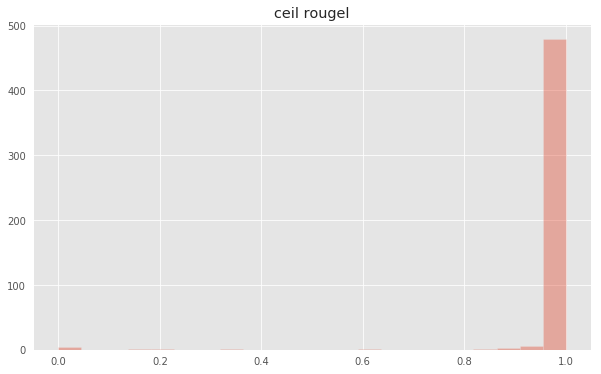

In [56]:
plt.figure(figsize=(10, 6))
sns.distplot(bad_case_rougel_samples, kde=False)
plt.title('ceil rougel')
plt.show()

In [57]:
print('total:', bad_case_rougel_samples.shape[0])
print('ceil rougel < 0.20:', bad_case_rougel_samples[bad_case_rougel_samples < 0.2].shape[0])
print('ceil rougel > 0.95:', bad_case_rougel_samples[bad_case_rougel_samples > 0.95].shape[0])
print('ceil rougel = 0:', bad_case_rougel_samples[bad_case_rougel_samples == 0].shape[0])
print('ceil rougel = 1:', bad_case_rougel_samples[bad_case_rougel_samples == 1].shape[0])
print('mean ceil rougel:', np.mean(bad_case_rougel_samples))

total: 498
ceil rougel < 0.20: 6
ceil rougel > 0.95: 479
ceil rougel = 0: 4
ceil rougel = 1: 474
mean ceil rougel: 0.9828555288692328


In [23]:
start_idx = []
end_idx = []

cuted_train_ceil_rougels = []
with open('../input/mrc_dataset/all_train_full_content.json') as f:
    for line in f:
        sample = json.loads(line.strip())
        cuted_train_ceil_rougels.append(sample['ceil_rougel'])
        
        for al in sample['answer_labels']:
            start_idx.append(al[1])
            end_idx.append(al[2])
        

In [24]:
cuted_train_ceil_rougels = np.array(cuted_train_ceil_rougels)

/home/lq/softwares/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


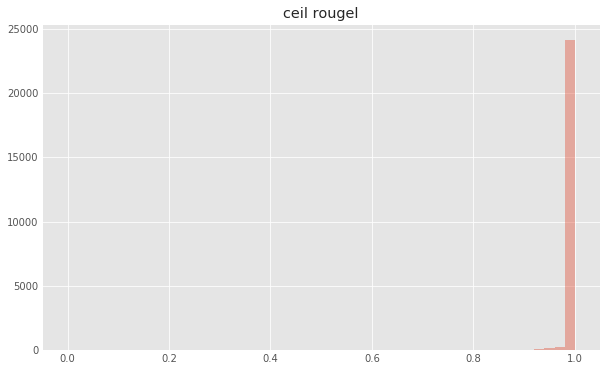

In [11]:
plt.figure(figsize=(10, 6))
sns.distplot(cuted_train_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [26]:
start_idx = np.array(start_idx)
end_idx = np.array(end_idx)

In [27]:
start_idx = start_idx[start_idx < 1000]
end_idx = end_idx[end_idx < 1000]

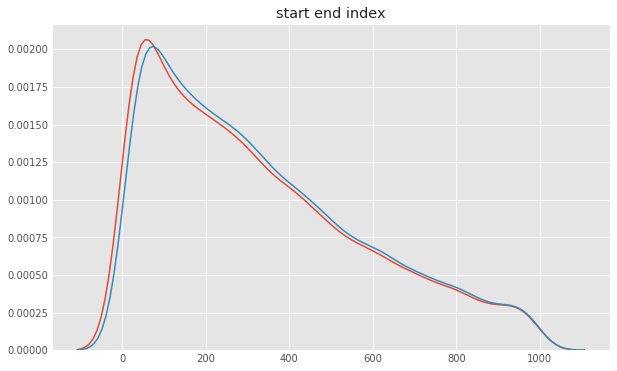

In [28]:
plt.figure(figsize=(10, 6))
sns.kdeplot(start_idx)
sns.kdeplot(end_idx)
plt.title('start end index')
plt.show()

In [12]:
print('total:', cuted_train_ceil_rougels.shape[0])
print('ceil rougel < 0.20:', cuted_train_ceil_rougels[cuted_train_ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', cuted_train_ceil_rougels[cuted_train_ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0])
print('ceil rougel = 1 percent:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0] / cuted_train_ceil_rougels.shape[0])
print('mean ceil rougel =', np.mean(cuted_train_ceil_rougels))

total: 24843
ceil rougel < 0.20: 7
ceil rougel > 0.95: 24508
ceil rougel = 0: 4
ceil rougel = 1: 23943
ceil rougel = 1 percent: 0.9637724912450187
mean ceil rougel = 0.9976791525641499


## 9.12 第二版数据

In [29]:
start_idx = []
end_idx = []
cuted_train_ceil_rougels = []
with open('../input/mrc_dataset_0912/train_max_content_len_{}.json'.format(max_content_len)) as f:
    for line in f:
        sample = json.loads(line.strip())
        cuted_train_ceil_rougels.append(sample['ceil_rougel'])
        
        for al in sample['answer_labels']:
            start_idx.append(al[1])
            end_idx.append(al[2])
        
        if sample['ceil_rougel'] == 0:
            print(sample['question_id'])
            

Q_07096kkkdj
Q_35449ydjjg
Q_46386jygqj


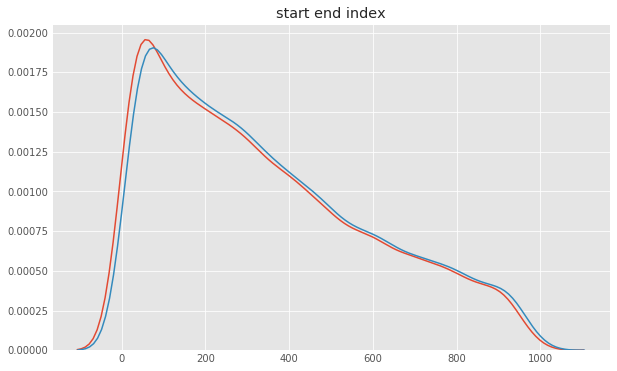

In [30]:
plt.figure(figsize=(10, 6))
sns.kdeplot(start_idx)
sns.kdeplot(end_idx)
plt.title('start end index')
plt.show()

## 训练集的 content 截断后的 ceil rougel

In [8]:
max_content_len = 1000

In [19]:
start_idx = []
end_idx = []
cuted_train_ceil_rougels = []
with open('../input/mrc_dataset/train_max_content_len_{}.json'.format(max_content_len)) as f:
    for line in f:
        sample = json.loads(line.strip())
        cuted_train_ceil_rougels.append(sample['ceil_rougel'])
        
        for al in sample['answer_labels']:
            start_idx.append(al[1])
            end_idx.append(al[2])
        
        if sample['ceil_rougel'] == 0:
            print(sample['question_id'])
            

Q_37636dyqhk
Q_07096kkkdj
Q_35449ydjjg
Q_28144ghnqs
Q_22946ygdjy
Q_46386jygqj


In [16]:
cuted_train_ceil_rougels = np.array(cuted_train_ceil_rougels)

/home/lq/softwares/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


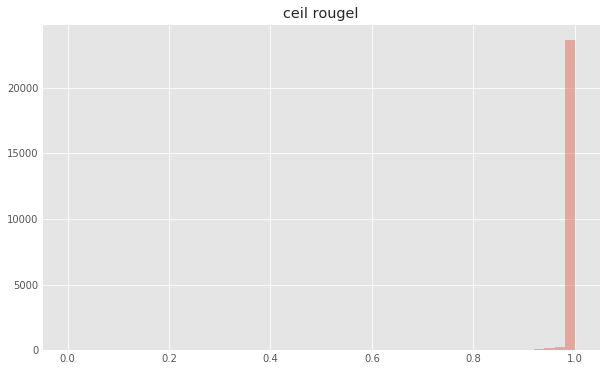

In [17]:
plt.figure(figsize=(10, 6))
sns.distplot(cuted_train_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

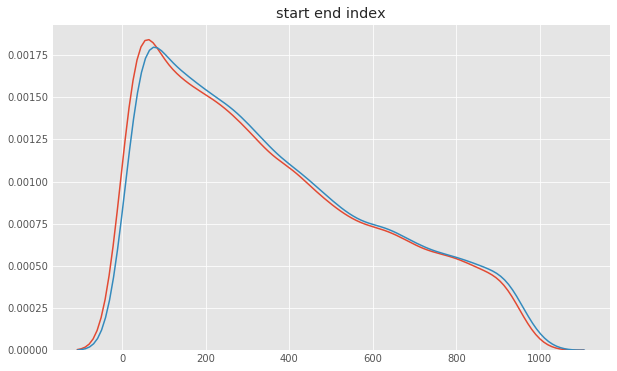

In [22]:
plt.figure(figsize=(10, 6))
sns.kdeplot(start_idx)
sns.kdeplot(end_idx)
plt.title('start end index')
plt.show()

In [18]:
print('total:', cuted_train_ceil_rougels.shape[0])
print('ceil rougel < 0.20:', cuted_train_ceil_rougels[cuted_train_ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', cuted_train_ceil_rougels[cuted_train_ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0])
print('ceil rougel = 1 percent:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0] / cuted_train_ceil_rougels.shape[0])
print('mean ceil rougel =', np.mean(cuted_train_ceil_rougels))

total: 24343
ceil rougel < 0.20: 9
ceil rougel > 0.95: 23998
ceil rougel = 0: 6
ceil rougel = 1: 23443
ceil rougel = 1 percent: 0.9630283859836504
mean ceil rougel = 0.9974170935528627


## Back translate train 

In [3]:
ori_ceil_rougels = []

for i in range(3):
    with open('../input/mrc_dataset/split_back_translated_train_0{}'.format(i)) as f:
        lines = f.readlines()
        for line in tqdm(lines):
            if not line.startswith('{'):
                continue

            sample = json.loads(line.strip())
            ori_ceil_rougels.append(sample['ceil_rougel'])

100%|██████████| 30/30 [00:00<00:00, 10063.91it/s]


In [5]:
ori_ceil_rougels = np.array(ori_ceil_rougels)

/home/lq/softwares/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


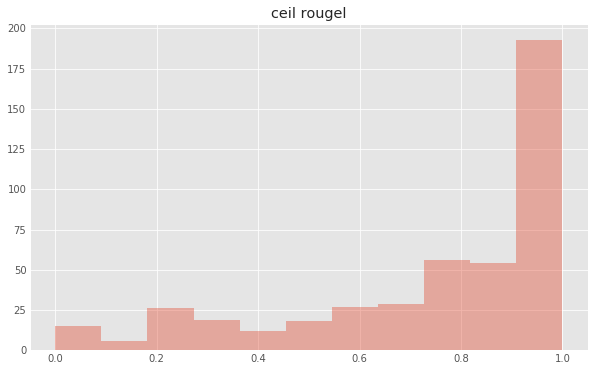

In [6]:
plt.figure(figsize=(10, 6))
sns.distplot(ori_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [12]:
!ls ../input/mrc_dataset_add_back_trans/

back_translate_train_max_content_len_1000.json
cached_test_pytorch_model.bin_512
dev.json
new_train_max_content_len_1000.json
test_r0.json
train_max_content_len_1000.json


In [13]:
start_idx = []
end_idx = []
cuted_train_ceil_rougels = []
with open('../input/mrc_dataset_add_back_trans/back_translate_train_max_content_len_{}.json'.format(max_content_len)) as f:
    for line in f:
        sample = json.loads(line.strip())
        cuted_train_ceil_rougels.append(sample['ceil_rougel'])
        
        for al in sample['answer_labels']:
            start_idx.append(al[1])
            end_idx.append(al[2])
        
        if sample['ceil_rougel'] == 0:
            print(sample['question_id'])

cuted_train_ceil_rougels = np.array(cuted_train_ceil_rougels)

/home/lq/softwares/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:218: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  color=hist_color, **hist_kws)


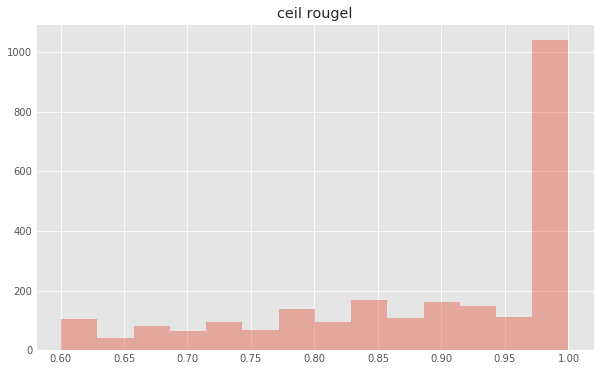

In [14]:
plt.figure(figsize=(10, 6))
sns.distplot(cuted_train_ceil_rougels, kde=False)
plt.title('ceil rougel')
plt.show()

In [15]:
print('total:', cuted_train_ceil_rougels.shape[0])
print('ceil rougel < 0.20:', cuted_train_ceil_rougels[cuted_train_ceil_rougels < 0.2].shape[0])
print('ceil rougel > 0.95:', cuted_train_ceil_rougels[cuted_train_ceil_rougels > 0.95].shape[0])
print('ceil rougel = 0:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 0].shape[0])
print('ceil rougel = 1:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0])
print('ceil rougel = 1 percent:', cuted_train_ceil_rougels[cuted_train_ceil_rougels == 1].shape[0] / cuted_train_ceil_rougels.shape[0])
print('mean ceil rougel =', np.mean(cuted_train_ceil_rougels))

total: 2432
ceil rougel < 0.20: 0
ceil rougel > 0.95: 1121
ceil rougel = 0: 0
ceil rougel = 1: 1006
ceil rougel = 1 percent: 0.4136513157894737
mean ceil rougel = 0.8913983439049908
